YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_13698/2639516442.py:117: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = web.DataReader('F-F_Research_data_5_factors_2x3',
/tmp/ipykernel_13698/2639516442.py:117: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = web.DataReader('F-F_Research_data_5_factors_2x3',


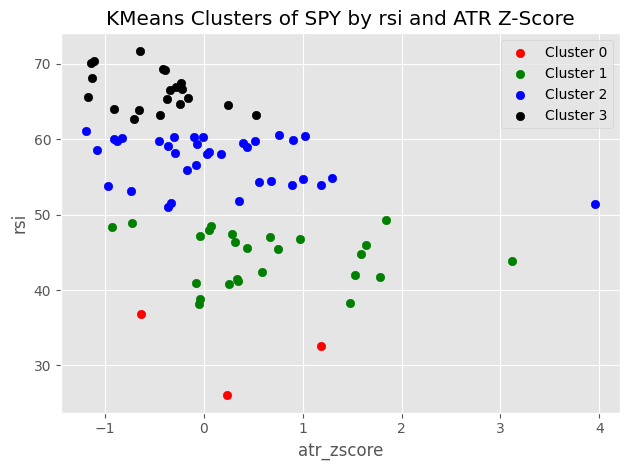

In [1]:
import pandas_datareader.data as web
import pandas as pd
import pandas_ta
import numpy as np  
import yfinance as yf
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# Code block to introduce all stocks under the S&P 500 index
# sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
# sp500['Symbol'] = sp500['Symbol'].str.replace('.','-')
# symbols_list = sp500['Symbol'].unique().tolist()
# to_remove = ['SOLV', 'VLTO', 'SW', 'GEV'] # Yfinance does not have legacy data for these tickers, consider reintegrating
# symbols_list = [symbol for symbol in symbols_list if symbol not in to_remove]

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:, 0]
    return macd.sub(macd.mean()).div(macd.std())


def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
        low=stock_data['low'],
        close=stock_data['close'],
        length=14)
    atr.dropna(inplace=True)
    z_atr = atr.sub(atr.mean()).div(atr.std())
    return z_atr


def calculate_returns(df):
    outlier_cutoff = 0.005
    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:
        df[f'return_{lag}m'] = (df['close']
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                       upper=x.quantile(1-outlier_cutoff)))
                                .add(1)
                                .pow(1/lag)
                                .sub(1))
    return df


def plot_clusters(data):
    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0['atr_zscore'], cluster_0['rsi'], color = 'red', label='Cluster 0')
    plt.scatter(cluster_1['atr_zscore'], cluster_1['rsi'], color = 'green', label='Cluster 1')
    plt.scatter(cluster_2['atr_zscore'], cluster_2['rsi'], color = 'blue', label='Cluster 2')
    plt.scatter(cluster_3['atr_zscore'], cluster_3['rsi'], color = 'black', label='Cluster 3')

    plt.xlabel('atr_zscore')
    plt.ylabel('rsi')
    plt.title('KMeans Clusters of SPY by rsi and ATR Z-Score')
    
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return


def get_clusters(data, initial_centroids):
    data['cluster'] = KMeans(n_clusters=4,
                          random_state=0,
                          init=initial_centroids).fit(data).labels_
    return data


end_date = '2025-05-01'
start_date = pd.to_datetime(end_date) - pd.DateOffset(years=8)


df = yf.download(tickers = 'SPY',
                start = start_date,
                end = end_date,
                timeout= 5.0)
                # .stack(future_stack=True)
df.columns = df.columns.get_level_values(0) 

df.columns = df.columns.str.lower()

df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['close'])-np.log(df['open']))**2)

df['rsi'] = pandas_ta.rsi(df['close'], length=20)

# Check RSI plot
# df.xs('SPY', level=1)['rsi'].plot(title='SPY RSI', figsize=(10, 5), color='blue') 

df['bb_low'] = df['close'].transform(lambda x:pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 0])
df['bb_mid'] = df['close'].transform(lambda x:pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 1])
df['bb_high'] = df['close'].transform(lambda x:pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 2])
df['atr_zscore'] = compute_atr(df)
df['macd'] = compute_macd(df['close'])
df['dollar_volume'] = (df['close'] * df['volume'])/1e6
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'open', 'high', 'low', 'volume']]

adjusted_volume = df['dollar_volume'].resample('ME').mean().to_frame('dollar_volume')
df_monthly = df[last_cols].resample('ME').last()

data = (pd.concat([adjusted_volume, df_monthly], axis=1)).dropna()
data['dollar_volume'] = data.loc[:, 'dollar_volume'].rolling(5*12, min_periods=12).mean().dropna()
data['dollar_vol_rank'] = (data['dollar_volume'].rank(ascending=False)).dropna()
data = data.drop(['dollar_volume', 'dollar_vol_rank'], axis=1)


data = calculate_returns(data).dropna()

factor_data = web.DataReader('F-F_Research_data_5_factors_2x3',
               'famafrench',
               start='2010')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('ME').last().div(100)
factor_data.index.name = 'date'
factor_data = factor_data.join(data['return_1m'])

endog = factor_data['return_1m']
exog = sm.add_constant(factor_data.drop(columns='return_1m',axis=1))
rolling_ols = RollingOLS(endog=endog, exog=exog, window=min(24,factor_data.shape[0]), min_nobs=len(factor_data.columns)+1)
rolling_betas = rolling_ols.fit(params_only=True).params.drop(columns='const', axis =1)
# rolling_betas
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
data = data.join(rolling_betas)
data.loc[:, factors] = data[factors].apply(lambda x: x.fillna(x.mean()))
data = data.drop('close', axis=1)
data = data.drop('cluster', axis=1, errors='ignore')

target_rsi_values = [30, 45, 55, 70]
feature_count = data.shape[1]
rsi_index = data.columns.get_loc("rsi")
initial_centroids = np.zeros((len(target_rsi_values),feature_count))
initial_centroids[:, rsi_index] = target_rsi_values
initial_centroids

data = get_clusters(data.dropna(), initial_centroids)

plt.style.use('ggplot')
plot_clusters(data)





# print(df)
# print(type(df.index))       # Shows the index type
# print(df.index.nlevels) 
# print(df.index.names)
# print(df.columns)

In [2]:
filtered_df = data[data['cluster'] == 1].copy()
filtered_df = filtered_df.reset_index() 
filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])
filtered_df['Date'] = filtered_df['Date'] + pd.DateOffset(1)
filtered_df
# dates = filtered_df['Date'].unique().tolist()
# dates = [d.strftime('%Y-%m-%d') for d in dates]
# dates
# fixed_dates = {}

# for d in dates: 
#     formatted_date = d.strftime('%Y-%m-%d')
#     matched_indices = filtered_df[filtered_df['Date'] == d].index.tolist()
#     fixed_dates[formatted_date] = matched_indices
    
# fixed_dates

,Date,garman_klass_vol,rsi,bb_low,bb_mid,bb_high,atr_zscore,macd,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m,Mkt-RF,SMB,HML,RMW,CMA,cluster
0,2018-07-01,0.000039,48.337291,5.493515,5.511968,5.530421,-0.932291,-0.300599,0.005751,0.014988,0.011704,0.004159,0.010090,0.011193,0.975613,-0.120816,0.001842,0.061068,0.048430,1
1,2018-11-01,0.000066,40.936164,5.465558,5.520493,5.575427,-0.082919,-1.397059,-0.069104,-0.032307,-0.011355,0.005326,-0.003085,0.005782,0.975613,-0.120816,0.001842,0.061068,0.048430,1
2,2019-01-01,0.000059,41.219212,5.367031,5.453545,5.540059,0.341951,-1.681295,-0.088048,-0.036222,-0.047310,-0.011874,-0.004077,-0.003890,0.985162,-0.147996,-0.030938,0.103597,0.025022,1
3,2020-02-01,0.000096,48.888219,5.695296,5.714788,5.734281,-0.725473,0.090071,-0.000404,0.014219,0.021493,0.014782,0.011671,0.016324,0.979611,-0.070503,-0.028817,0.161016,0.082018,1
4,2020-04-01,0.000329,43.792844,5.310336,5.487484,5.664632,3.115017,-3.420347,-0.109793,-0.085889,-0.063740,-0.021466,-0.012456,-0.005932,0.974309,-0.072583,-0.072512,0.141631,0.129604,1
5,2020-11-01,0.000225,41.514260,5.730065,5.771922,5.813779,0.338468,-0.655915,-0.024933,-0.031209,0.001353,0.021121,0.003237,0.007770,0.949779,-0.156638,0.020743,-0.051017,0.082441,1
6,2021-02-01,0.000168,47.905302,5.852673,5.877359,5.902045,0.055860,0.244640,-0.010191,0.013154,0.044075,0.022491,0.028715,0.013294,0.935593,-0.173170,0.030825,-0.000757,0.055396,1
7,2021-03-01,0.000143,48.467940,5.868968,5.899875,5.930782,0.068085,0.149738,0.027805,0.008628,0.018014,0.015690,0.026532,0.022617,0.930448,-0.179338,0.054284,-0.007362,0.030735,1
8,2021-10-01,0.000073,38.879598,6.014947,6.044105,6.073262,-0.037497,-0.852554,-0.046605,-0.009158,0.001908,0.014437,0.016533,0.022071,0.919360,-0.148750,0.033923,0.080386,0.057145,1
9,2021-12-01,0.000104,47.128528,6.080316,6.096064,6.111812,-0.042553,0.255668,-0.008035,0.030323,0.004014,0.014714,0.021352,0.020516,0.927823,-0.169909,0.045579,0.053863,0.050948,1


In [3]:
# from pypfopt.efficient_frontier import EfficientFrontier
# from pypfopt import risk_models
# from pypfopt import expected_returns
# from pypfopt import BlackLittermanModel


# def optimize_weights(prices, lower_bound=0):
#     cov = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
#     pi = expected_returns.capm_return(prices, market_prices=spy_df['Close'])
#     bl = BlackLittermanModel(cov, pi="equal"))
#     views = {"SPY": 0.02}             
#     confidences = {"SPY": 0.10}   
#     blend_returns = bl.bl_returns(absolute_views=views, view_confidences=confidences)
    
#     ef = efficient_frontier.EfficientFrontier(blend_returns, cov, weight_bounds=(lower_bound, 0.1))
#     ef.max_sharpe()
#     return ef.clean_weights()
    

In [4]:
# 1) Download full daily SPY data
new_df = yf.download('SPY', start=start_date, end=end_date)
if isinstance(new_df.columns, pd.MultiIndex):
    new_df.columns = new_df.columns.droplevel('Ticker')

# 2) Build monthly close series at month-start
monthly_close = new_df['Close'].resample('MS').first()\
                 .rename('Close')

# 3) Make sure filtered_df.Date is datetime, then set it as index
filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])
filtered_df = filtered_df.set_index('Date')

# 4) Join on that Date-index
filtered_df = filtered_df.join(monthly_close, how='left')
filtered_df

[*********************100%***********************]  1 of 1 completed


,garman_klass_vol,rsi,bb_low,bb_mid,bb_high,atr_zscore,macd,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m,Mkt-RF,SMB,HML,RMW,CMA,cluster,Close
Date,,,,,,,,,,,,,,,,,,,,
2018-07-01,0.000039,48.337291,5.493515,5.511968,5.530421,-0.932291,-0.300599,0.005751,0.014988,0.011704,0.004159,0.010090,0.011193,0.975613,-0.120816,0.001842,0.061068,0.048430,1,244.085403
2018-11-01,0.000066,40.936164,5.465558,5.520493,5.575427,-0.082919,-1.397059,-0.069104,-0.032307,-0.011355,0.005326,-0.003085,0.005782,0.975613,-0.120816,0.001842,0.061068,0.048430,1,246.678467
2019-01-01,0.000059,41.219212,5.367031,5.453545,5.540059,0.341951,-1.681295,-0.088048,-0.036222,-0.047310,-0.011874,-0.004077,-0.003890,0.985162,-0.147996,-0.030938,0.103597,0.025022,1,226.954773
2020-02-01,0.000096,48.888219,5.695296,5.714788,5.734281,-0.725473,0.090071,-0.000404,0.014219,0.021493,0.014782,0.011671,0.016324,0.979611,-0.070503,-0.028817,0.161016,0.082018,1,299.598297
2020-04-01,0.000329,43.792844,5.310336,5.487484,5.664632,3.115017,-3.420347,-0.109793,-0.085889,-0.063740,-0.021466,-0.012456,-0.005932,0.974309,-0.072583,-0.072512,0.141631,0.129604,1,228.865189
2020-11-01,0.000225,41.514260,5.730065,5.771922,5.813779,0.338468,-0.655915,-0.024933,-0.031209,0.001353,0.021121,0.003237,0.007770,0.949779,-0.156638,0.020743,-0.051017,0.082441,1,309.598541
2021-02-01,0.000168,47.905302,5.852673,5.877359,5.902045,0.055860,0.244640,-0.010191,0.013154,0.044075,0.022491,0.028715,0.013294,0.935593,-0.173170,0.030825,-0.000757,0.055396,1,354.260376
2021-03-01,0.000143,48.467940,5.868968,5.899875,5.930782,0.068085,0.149738,0.027805,0.008628,0.018014,0.015690,0.026532,0.022617,0.930448,-0.179338,0.054284,-0.007362,0.030735,1,366.830719
2021-10-01,0.000073,38.879598,6.014947,6.044105,6.073262,-0.037497,-0.852554,-0.046605,-0.009158,0.001908,0.014437,0.016533,0.022071,0.919360,-0.148750,0.033923,0.080386,0.057145,1,412.882629


In [5]:


spy_ret = np.log(filtered_df[['Close']]).diff().dropna().rename({'Close':'Spy Buy&Hold'}, axis=1)

spy_ret

# for start_date in dates:
#     end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
#     # cols = fixed_dates[start_date]
#     optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
#     optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')


,Spy Buy&Hold
Date,
2018-11-01,0.010568
2019-01-01,-0.083335
2020-02-01,0.277692
2020-04-01,-0.269309
2020-11-01,0.302143
2021-02-01,0.134756
2021-03-01,0.034868
2021-10-01,0.118263
2021-12-01,0.036761


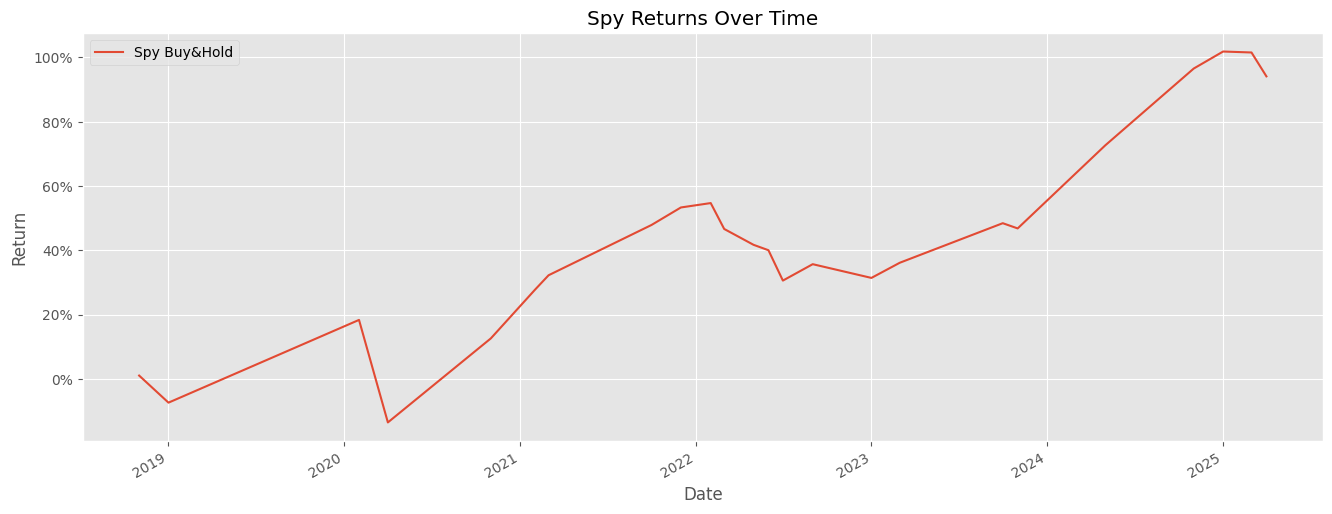

In [6]:
import matplotlib.ticker as mtick
plt.style.use('ggplot')
spy_ret = np.exp(np.log1p(spy_ret).cumsum())-1
spy_ret[:'2025-04-29'].plot(figsize=(16,6))
plt.title('Clustered Spy Returns Over Time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()